In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

Compare K-means, DBSCAN and Agglomerative clustering
* Initialize: K-means' results can be influenced by the random initialization of centroids, while DBSCAN is not as sensitive to initialization, and Agglomerative clustering doesn't require any specific initialization.
* K-means requires users to decide the value of 'k' (number of clusters) themselves, while DBSCAN does not require setting a fixed number of clusters, and Agglomerative clustering offers more flexibility. Users can set the number of clusters or a distance threshold as a stopping criterion.
* Cluster shape: K-means generates clusters with similar sizes and simple shapes, making it less suitable for clustering complex data. In contrast, both DBSCAN and Agglomerative clustering can handle complex shapes and identify outliers. DBSCAN is based on density, while Agglomerative clustering is a hierarchical clustering method.
* Runtime: Agglomerative > DBSCAN > K-Means

## Import Functions

In [2]:
import warnings
warnings.filterwarnings("ignore")
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score

np.random.seed(0)

def get_training_data(n_samples = 500):
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
    no_structure = np.random.rand(n_samples, 2), None

    # Anisotropicly distributed data
    random_state = 170
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(
        n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
    )

    config = [[2, 0.2, 5], [2, 0.3, 5], [3, 1, 5], [3, 0.15, 5], [3, 0.3, 5], [3, 1, 5]] #k, eps, min_sample 

    return [noisy_circles[0], noisy_moons[0], blobs[0], no_structure[0], aniso[0], varied[0]], config

def plot_results(X, custom_kmeans, sklearn_kmeans, custom_dbscan, sklearn_dbscan, training_time):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].scatter(X[:, 0], X[:, 1], c='b', label='Data')
    axs[0].set_title('Original Data')

    axs[1].scatter(X[:, 0], X[:, 1], c=custom_kmeans, cmap='viridis')
    axs[1].set_title('Custom KMeans Clustering')
    axs[1].text(0.67, 0.95, f"Time: {training_time[0]:.4f} s", transform=axs[1].transAxes)

    axs[2].scatter(X[:, 0], X[:, 1], c=sklearn_kmeans, cmap='viridis')
    axs[2].set_title('Scikit-learn KMeans Clustering')
    axs[2].text(0.67, 0.95, f"Time: {training_time[1]:.4f} s", transform=axs[2].transAxes)

    axs[3].scatter(X[:, 0], X[:, 1], c=custom_dbscan, cmap='viridis')
    axs[3].set_title('Custom DBSCAN Clustering')
    axs[3].text(0.67, 0.95, f"Time: {training_time[2]:.4f} s", transform=axs[3].transAxes)

    axs[4].scatter(X[:, 0], X[:, 1], c=sklearn_dbscan, cmap='viridis')
    axs[4].set_title('Scikit-learn DBSCAN Clustering')
    axs[4].text(0.67, 0.95, f"Time: {training_time[3]:.4f} s", transform=axs[4].transAxes)

    plt.tight_layout()
    plt.show()

## Load Data

In [3]:
dataset, config = get_training_data()

## K-Means

In [4]:
class kmeans:
    def __init__(self, X, k):
        self.k = k
        self.X = X
        self.centroids = None
        self.clusters = None

    def initialize(self):
        random_indices = np.random.choice(len(self.X), self.k, replace=False)
        self.centroids = self.X[random_indices]

    def clustering(self):
        distances  = []
        for i in self.centroids:
            distance = np.linalg.norm((self.X - i), axis = 1)
            distances.append(distance)
        distances = np.array(distances)
        self.clusters = np.argmin(distances, axis = 0)

    def update(self):
        for i in range(self.k):
            self.centroids[i] = np.mean(self.X[self.clusters == i], axis=0)

    def train(self, max_iter = 100000, tolerance = 1e-4):
        #print("Start training...")
        start = time.time()
        self.initialize()
        for i in range(max_iter):
            last_clusters = np.copy(self.clusters)
            self.clustering()
            self.update()
            if np.array_equal(last_clusters, self.clusters):
                break
        #print(f"Trained {i} epochs in {time.time()-start} seconds.")
        return self.clusters

## DBSCAN

In [5]:
class dbscan:
    def __init__(self, X, eps = 0.3, min_pts = 3):
        self.X = X
        self.eps = eps
        self.min_pts = min_pts
        self.clusters = [-1] * len(X)
        self.visited = [False] * len(X)
        self.cur_cluster = 0
    
    def find_neighbors(self, idx):
        neighbors = []
        for i, x in enumerate(self.X):
            if np.linalg.norm(self.X[idx] - x) <= self.eps:
                neighbors.append(i)
        return neighbors

    def expand_clusters(self, idx):
        neighbors = self.find_neighbors(idx)
        if len(neighbors) < self.min_pts:
            self.clusters[idx] = -1
            return
        self.clusters[idx] = self.cur_cluster
        for neighbor in neighbors:
            if not self.visited[neighbor]:
                self.visited[neighbor] = True
                neighbor_stage2 = self.find_neighbors(neighbor)
                if len(neighbor_stage2) > self.min_pts:
                    neighbors += neighbor_stage2
            self.clusters[neighbor] = self.cur_cluster
        self.cur_cluster += 1

    def train(self):
        points = len(self.X)
        for i in range(points):
            if not self.visited[i]:
                self.visited[i] = True
                self.expand_clusters(i)
        return np.array(self.clusters)

## Training

sikhouette score:  [0.35225630656365586, 0.35596309779495994, 0.11077847786208478, 0.11077847786208478]


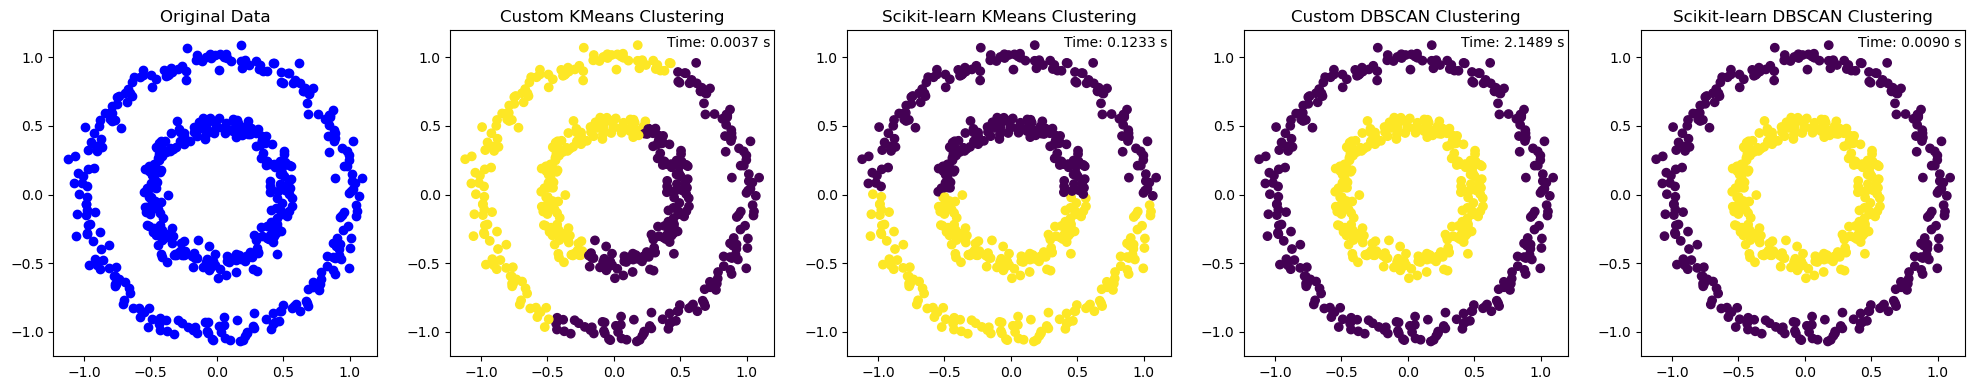

sikhouette score:  [0.48625693142612203, 0.48625693142612203, 0.334510429082777, 0.334510429082777]


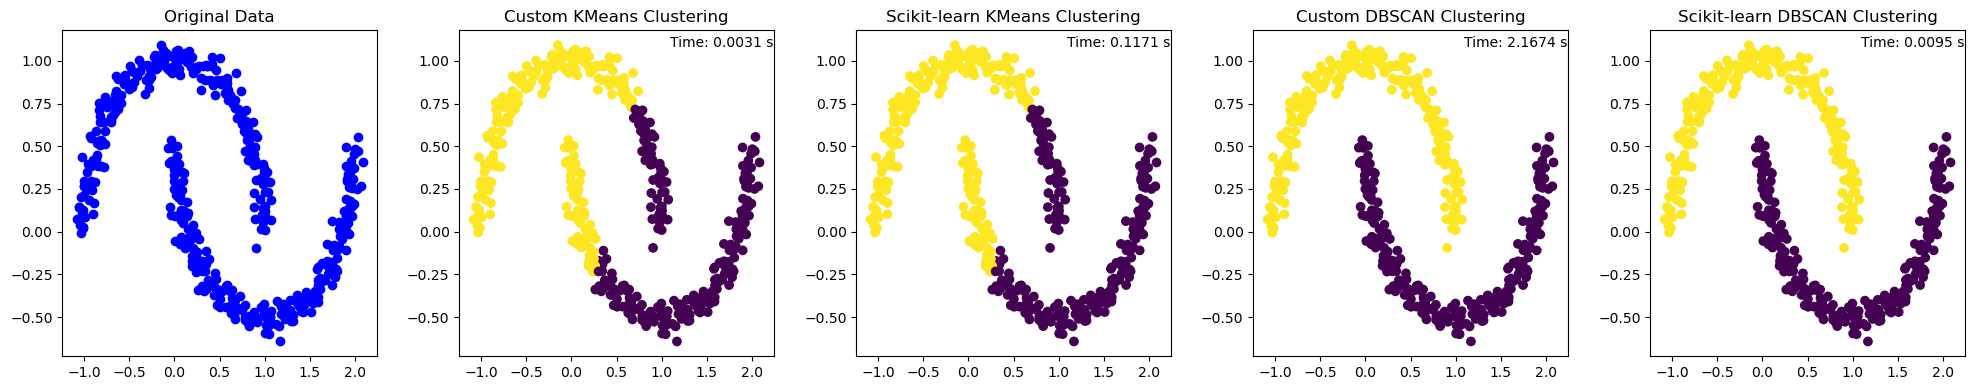

sikhouette score:  [0.8229367222836427, 0.8229367222836427, 0.7930102953005468, 0.7930102953005468]


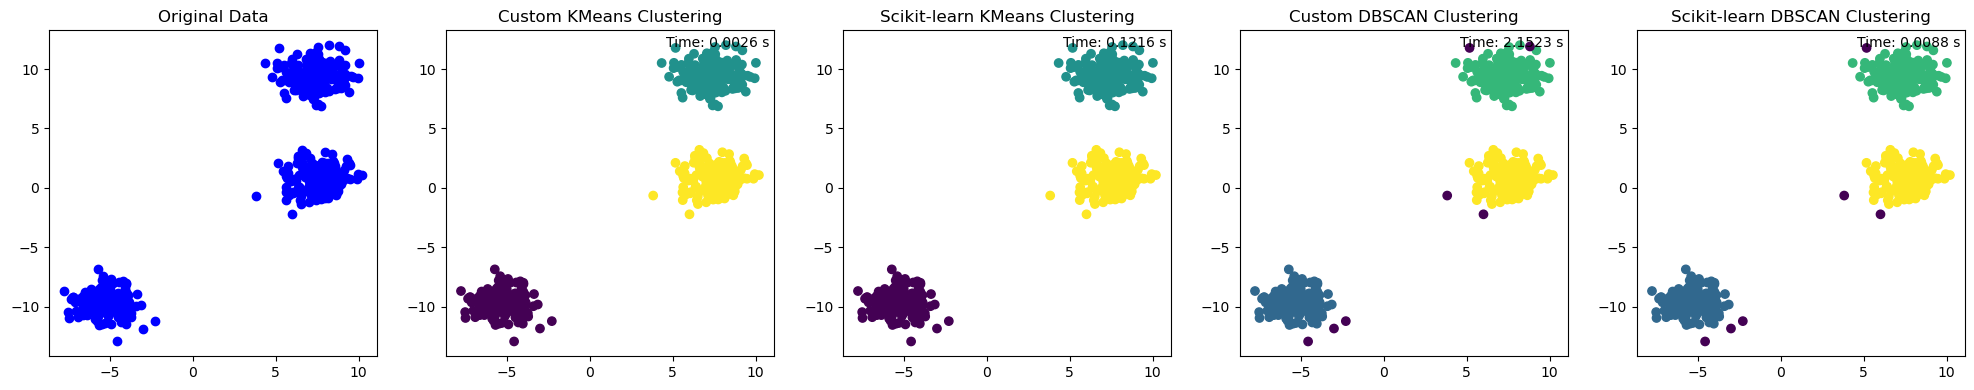

sikhouette score:  [0.40480103250268024, 0.40480103250268024, '1 cluster only', '1 cluster only']


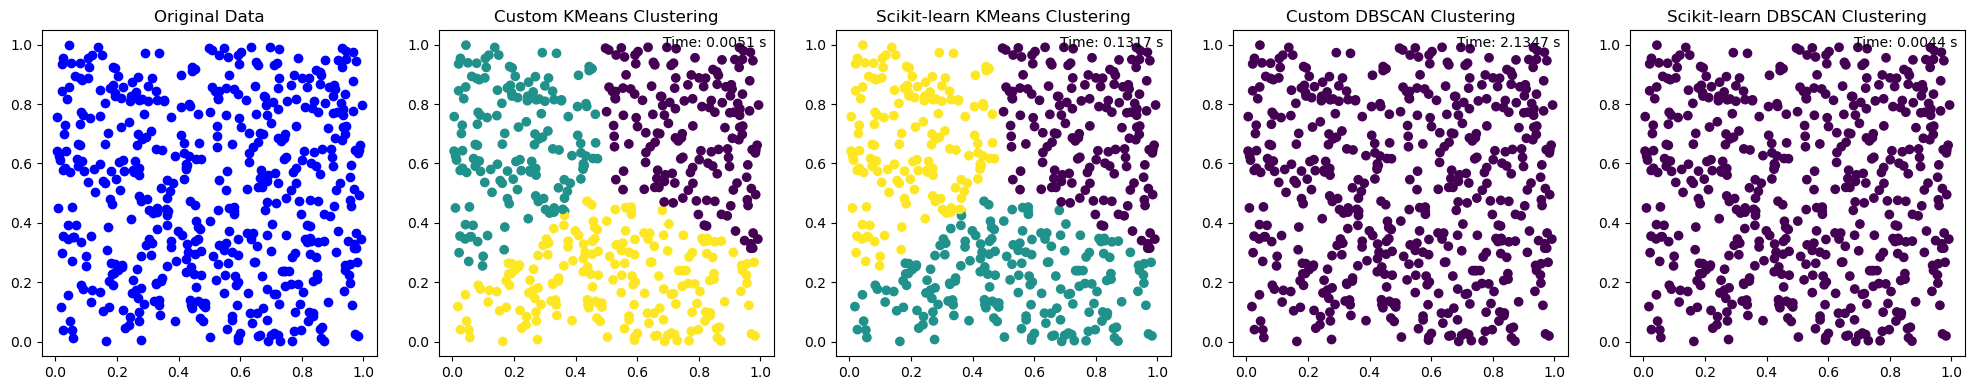

sikhouette score:  [0.502678758980691, 0.5009630274765694, 0.2714302783256573, 0.2714302783256573]


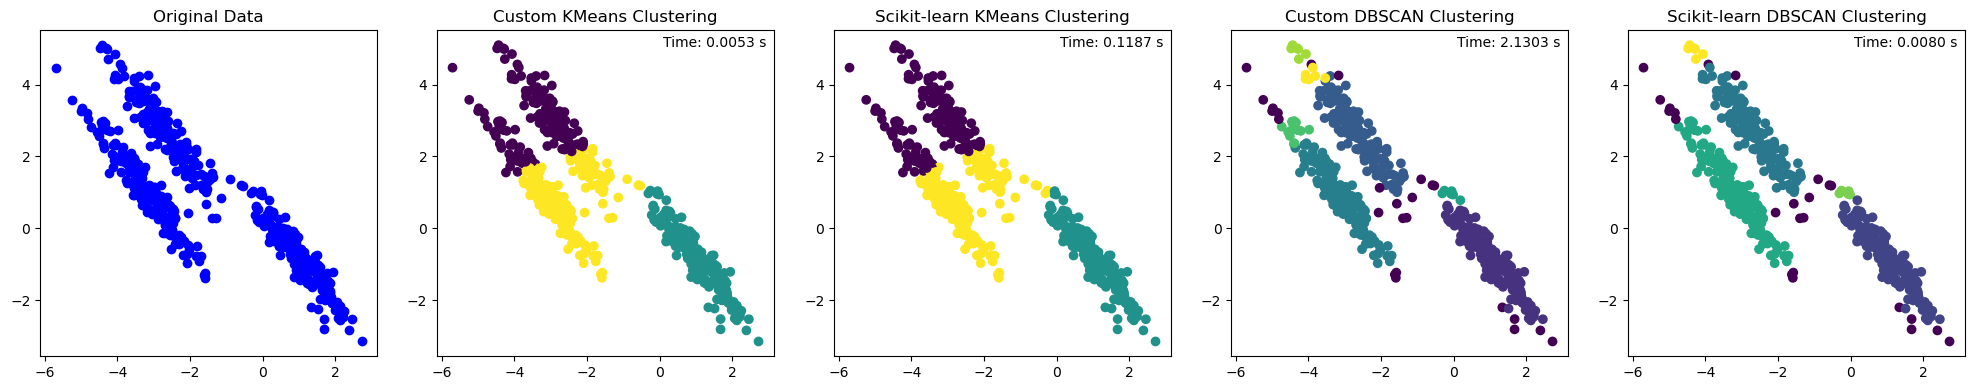

sikhouette score:  [0.6548557086159974, 0.6548557086159974, 0.522918692630876, 0.522918692630876]


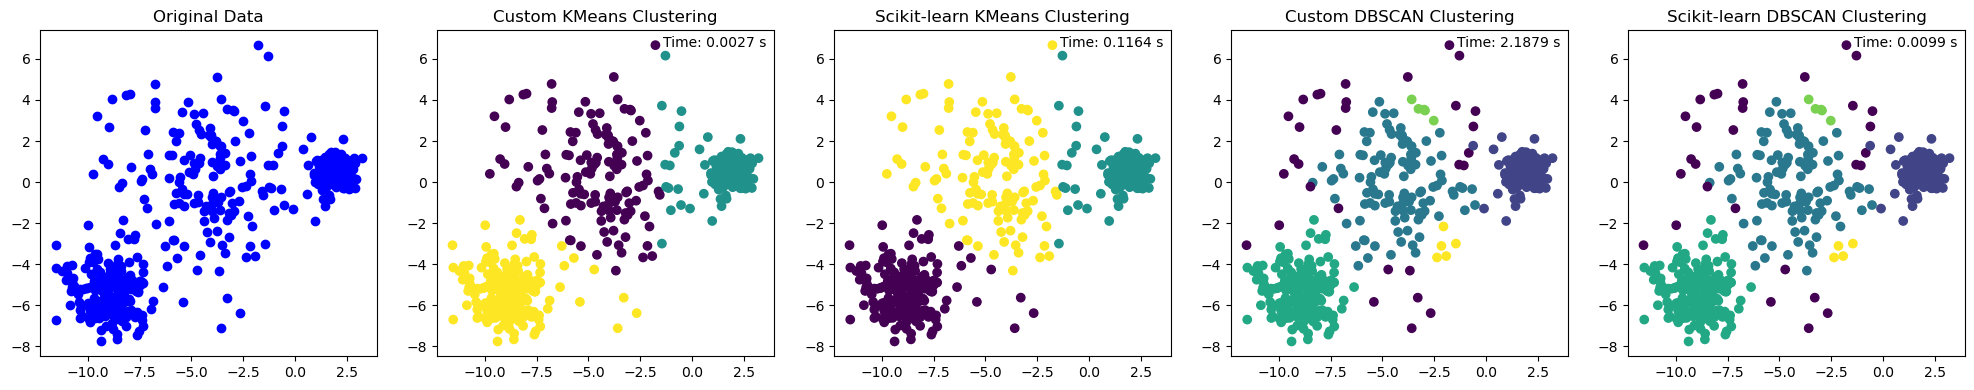

In [6]:
for X, params in zip(dataset, config):
    training_time = []
    scores = []

    start = time.time()
    model = kmeans(X, params[0])
    custom_kmeans = model.train()
    training_time.append(time.time() - start)
    scores.append(silhouette_score(X, custom_kmeans))
    

    start = time.time()
    model = cluster.KMeans(n_clusters = params[0])
    model.fit(X)
    sklearn_kmeans = model.labels_
    training_time.append(time.time() - start)
    scores.append(silhouette_score(X, sklearn_kmeans))

    start = time.time()
    model = dbscan(X, params[1], params[2])
    custom_dbscan = model.train()
    training_time.append(time.time() - start)
    try:
        scores.append(silhouette_score(X, custom_dbscan))
    except:
        scores.append('1 cluster only')
    
    start = time.time()
    model = cluster.DBSCAN(eps=params[1], min_samples=params[2])
    sklearn_dbscan = model.fit_predict(X)
    training_time.append(time.time() - start)
    try:
        scores.append(silhouette_score(X, custom_dbscan))
    except:
        scores.append('1 cluster only')

    print('sikhouette score: ', scores)

    plot_results(X, custom_kmeans, sklearn_kmeans, custom_dbscan, sklearn_dbscan, training_time)

# Experiment

#### Use 6 datasets from sklearn 
##### i. Compare performance using Silhouette coefficient and explain
Although K-means tends to have higher silhouette scores, this is because the algorithm assigns a higher score to well-separated and compact clusters, which is particularly favorable for K-means. On the other hand, DBSCAN clusters based on density, allowing it to produce more appropriate results for complex distributions (as shown in the first and second figures). However, due to the nature of the silhouette score calculation, such results may receive lower scores. Therefore, the silhouette score alone should not be the sole criterion for judging clustering quality
##### ii. Visualize your results (compare with original data, your code, sklearn tool) and explain
* Hand-crafted models have similar results to Sklearn models, which proves that the implementation is overall correct. The difference between the two K-means outputs in noisy_circles shows that the result will be influenced by the initialized centroids.
* K-means works well when the data is in equal-sized clusters and well-separated, for example, blobs. However, when facing non-spherical clusters or clusters with overlapping, it has poor performance, for example, noisy_circles, noisy_moons, and aniso. The no_structure dataset shows that the output of k-means is well-separated.
* DBSCAN works better on complex non-spherical clusters because it is density-based. As a result, it works better than K-means on noisy_circles and noisy_moons. However, choosing appropriate parameters is important. If the eps is too big, it might result in all data points being assigned to a single cluster. And if it's set too small or the num_sample is not set appropriately, there might be a lot of small clusters, for example, the result of aniso.

#### Explain the difference between two clustering algorithms you choose
* K-means assigns every single point to a cluster, while DBSCAN has the ability to identify outliers.
* K-means requires the user to define the number of clusters, while DBSCAN doesn't need this specification.
* DBSCAN requires more parameter tuning (eps, num_samples).
* K-means generates well-separated and similar-shaped clusters, while DBSCAN is density-based and can handle clusters of arbitrary shapes.